tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


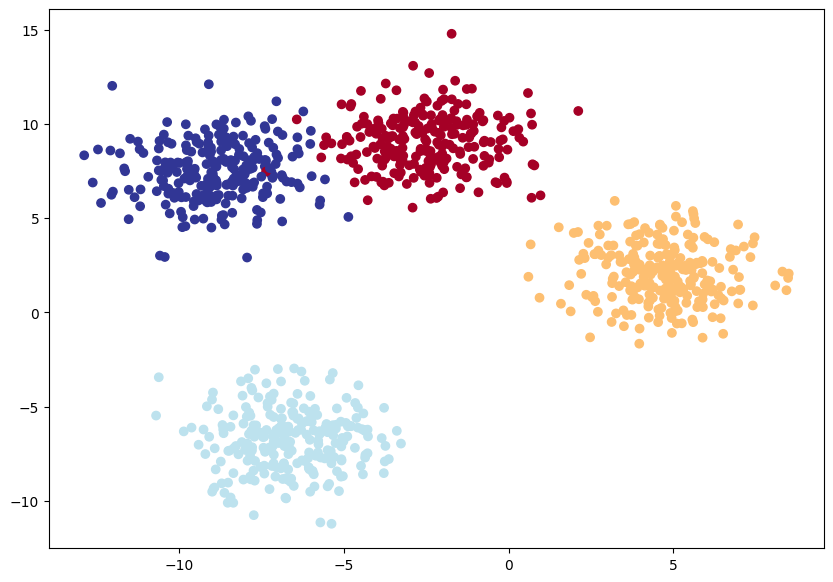

In [1]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);


In [2]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), 
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), 
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_0 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=6).to(device)
model_0

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=6, bias=True)
    (3): ReLU()
    (4): Linear(in_features=6, out_features=4, bias=True)
  )
)

In [4]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), 
                            lr=0.1)

In [5]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [6]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 101

# Create empty loss lists to track values
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
    
# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_0(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
     
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 
   
    train_loss_list.append(loss.detach().numpy())
    test_loss_list.append(test_loss.detach().numpy())
    train_acc_list.append(acc)
    test_acc_list.append(test_acc)
    float_train_loss_list = [tensor.item() for tensor in train_loss_list]
    float_test_loss_list = [tensor.item() for tensor in test_loss_list]




Epoch: 0 | Loss: 2.17345, Acc: 24.62% | Test Loss: 1.15731, Test Acc: 47.00%
Epoch: 10 | Loss: 0.11475, Acc: 98.50% | Test Loss: 0.09511, Test Acc: 98.00%
Epoch: 20 | Loss: 0.02293, Acc: 99.38% | Test Loss: 0.00356, Test Acc: 100.00%
Epoch: 30 | Loss: 0.02675, Acc: 99.50% | Test Loss: 0.00813, Test Acc: 99.50%
Epoch: 40 | Loss: 0.02459, Acc: 99.38% | Test Loss: 0.00149, Test Acc: 100.00%
Epoch: 50 | Loss: 0.01974, Acc: 99.50% | Test Loss: 0.00198, Test Acc: 100.00%
Epoch: 60 | Loss: 0.01746, Acc: 99.38% | Test Loss: 0.00291, Test Acc: 100.00%
Epoch: 70 | Loss: 0.01710, Acc: 99.38% | Test Loss: 0.00426, Test Acc: 100.00%
Epoch: 80 | Loss: 0.01714, Acc: 99.38% | Test Loss: 0.00451, Test Acc: 100.00%
Epoch: 90 | Loss: 0.01707, Acc: 99.50% | Test Loss: 0.00437, Test Acc: 100.00%
Epoch: 100 | Loss: 0.01702, Acc: 99.50% | Test Loss: 0.00392, Test Acc: 100.00%


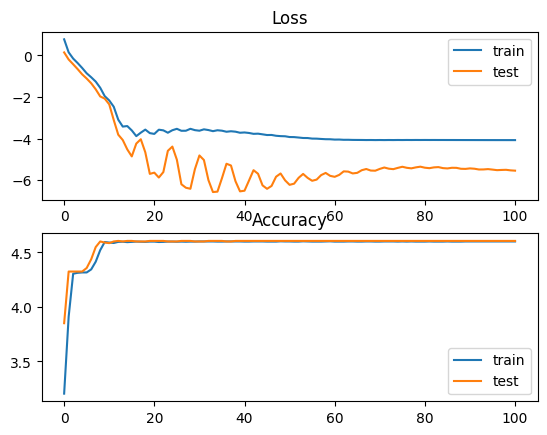

In [7]:
import numpy as np

# plot loss during training and testing
plt.subplot(211)
plt.title('Loss')
plt.plot(range(epochs), np.log(float_train_loss_list), label='train')
plt.plot(range(epochs), np.log(float_test_loss_list), label='test')
plt.legend()
# plot accuracy during training and testing
plt.subplot(212)
plt.title('Accuracy')
plt.plot(range(epochs), np.log(train_acc_list), label='train')
plt.plot(range(epochs), np.log(test_acc_list), label='test')
plt.legend()
plt.show()

In [8]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
   
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(
        np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

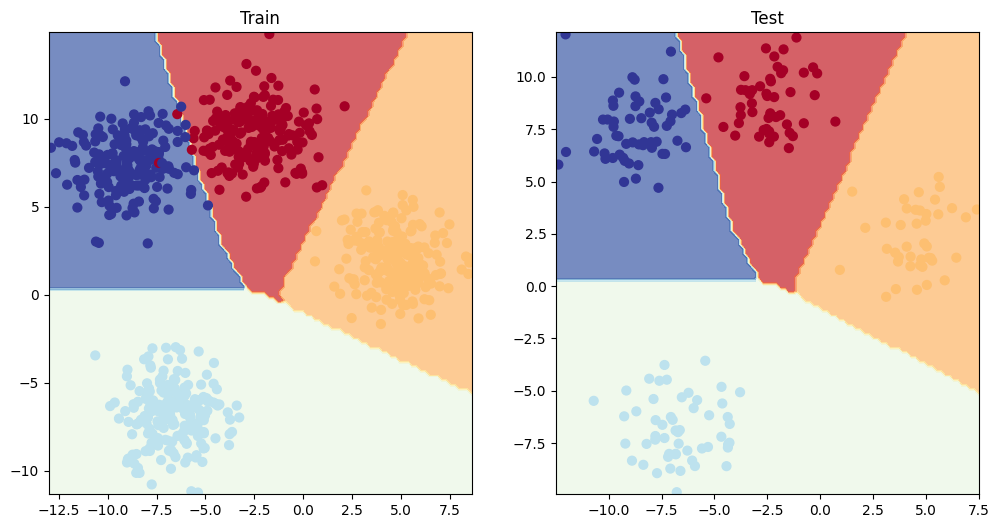

In [9]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_blob_train, y_blob_train) 
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_blob_test, y_blob_test) 